# 03.02 Basic Models in TensorFlow (Linear Regression + placeholder + MSE) 

### Placeholder

장점 : TensorFlow 외부에서 데이터 처리를 수행하여 Python으로 쉽게 주입 할 수 있습니다.  
단점 :실행 속도를 저하시키는 데이터 병목 현상을 만듭니다.  

### tf.data

데이터를 나중에 주입 하지만 TensorFlow가 직접 데이터를 처리 관리 한다.  

###  from_tensor_slices 함수
tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다.   
예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.  

tf.data.Dataset.from_tensor_slices((features, labels))  
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))  
print(dataset.output_types)		# >> (tf.float32, tf.float32)  
print(dataset.output_shapes)		# >> (TensorShape([]), TensorShape([]))  


### 파일에서 데이터 세트를 만듬

tf.data.TextLineDataset(filenames)  
tf.data.FixedLengthRecordDataset(filenames)  
tf.data.TFRecordDataset(filenames)  

### tf.data.Iterator 함수
데이터 세트의 샘플을 반복해서 만들기

iterator = dataset.make_one_shot_iterator()  
데이터 세트를 한번 반복합니다. 초기화 할 필요가 없습니다.  
iterator = dataset.make_initializable_iterator()  
우리가 원하는 만큼 여러번 데이터집합을 하고 초기화 해야합니다.  

iterator = dataset.make_one_shot_iterator()  
X, Y = iterator.get_next() # X is the birth rate, Y is the life expectancy  
with tf.Session() as sess:      
>print(sess.run([X, Y]))		# >> [1.822, 74.82825]  1 열의 값  
>print(sess.run([X, Y]))		# >> [3.869, 70.81949]  2 열의 값  
>print(sess.run([X, Y]))		# >> [3.911, 72.15066]  3 열의 값  

### TensorFlow에서 Data 처리

dataset = dataset.shuffle(1000)  
dataset = dataset.repeat(100)  
dataset = dataset.batch(128)  
dataset = dataset.map(lambda x: tf.one_hot(x, 10)) # 데이터 집합의 각 요소를 one_hot 벡터로 변환  

### 성능 비교

With placeholder: 9.05271519 seconds  
With tf.data: 6.12285947 seconds  

### tf.data 사용에 대한 예외 상황

prototype의 경우 feed dict가 더 빠르고 쉽게 작성할 수 있습니다.    
tf.data는 복잡한 전처리 또는 여러 데이터 소스가 있을때 사용하기가 까다롭습니다.  
NLP 데이터는 일반적으로 순차적인 정수여서 이 경우 GPU로 데이터를 전송하는 것은 매우 빠르므로 tf.data의 속도가 그다지 크지 않습니다.    

### Optimizer 
Optimizer는 Loss를 최소화 하기 위한 도구 이며 최소화 하기 위한 모든 학습 가능한 변수를 보고하고 세션은 업데이트합니다.

![Alt_text](./03_images/04.png)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/JunChangWook/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
DATA_FILE= 'data/birth_life_2010.txt'

In [4]:
def read_birth_life_data(filename):
    """
     birth_life_2010.txt를 읽고
     NumPy 배열 (data) 와 샘플수 (n_samples)를 반환 한다. 
    """
    text = open(filename, 'r').readlines()[1:] # 파일 전체를 읽는다.
    data = [line[:-1].split('\t') for line in text] # tab으로 자른다. 끝까지  그럼 나라  생일/t출생률/t기대수명/t
    births = [float(line[1]) for line in data] # 출생률 값을 가져 온다. 
    lifes = [float(line[2]) for line in data] # 기대수명 값을 가져 온다.
    data = list(zip(births, lifes)) # 두개를 묶어서 List로 변환 한다.
    n_samples = len(data) # list 전체 길이를 가져온다.
    data = np.asarray(data, dtype=np.float32) # list를 np array로 변경하기 위해서 np.asarray를 사용하고 있다.
    return data, n_samples

### Step 1: 데이터 읽어오기 

In [5]:
data, n_samples = read_birth_life_data(DATA_FILE)

### Step 2: placeholder 생성하고 값 가져오기

In [6]:
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

### Setp 3: 초기화 0인 Weight 와 Bias 만들기

In [7]:
w = tf.get_variable('weights', initializer=tf.constant(0.0))
b = tf.get_variable('bias', initializer=tf.constant(0.0))

### Step 4: 예측하기 위한 모델을 만든다.

In [8]:
Y_predicted = w * X + b

### Setp 5: 손실 함수로 square error를 사용

In [9]:
loss = tf.square(Y - Y_predicted, name='loss')

### Step 6: 학습 속도가 0.001 인 기울기 하강을 사용하여 손실 최소화 사용

In [10]:
# Step 6
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [11]:
start = time.time()
with tf.Session() as sess:
    # Step 7: w , b 변수를 초기화
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./graphs/linear_reg/', tf.get_default_graph())
    
    # Step 8: 100 epoch를 위한 Model 구성
    for i in range(100):
        total_loss = 0
        for x, y in data:
            # 세션은 최적화 프로그램을 실행하고 손실 값을 가져옵니다.
            _, l = sess.run([optimizer, loss], feed_dict={X:x, Y:y})
            total_loss += l
        print('Epoch {0}: {1}'.format(i, total_loss/n_samples))
        
    # 모든 구문을 수행을 완료 하면 graph를 닫자.
    writer.close()
    
    # Step 9: w, b 값을 출력 
    w_out, b_out = sess.run([w, b])
    
print('Took: %f seconds' % (time.time() - start))

Epoch 0: 1661.863764550287
Epoch 1: 956.3224439573916
Epoch 2: 844.6737683409139
Epoch 3: 750.7312372197838
Epoch 4: 667.659830722252
Epoch 5: 594.1417484349327
Epoch 6: 529.0787271179651
Epoch 7: 471.5003584364135
Epoch 8: 420.5458252520938
Epoch 9: 375.45531067297253
Epoch 10: 335.55436177954664
Epoch 11: 300.24627770512666
Epoch 12: 269.00374521501146
Epoch 13: 241.3595776562824
Epoch 14: 216.9003910217238
Epoch 15: 195.25972397061292
Epoch 16: 176.1137731664483
Epoch 17: 159.17551683403158
Epoch 18: 144.19069889799545
Epoch 19: 130.93503690609023
Epoch 20: 119.20935661137888
Epoch 21: 108.83793506244884
Epoch 22: 99.66458668207358
Epoch 23: 91.55171666162971
Epoch 24: 84.37658985632197
Epoch 25: 78.03213362396008
Epoch 26: 72.42178616552172
Epoch 27: 67.46132107331957
Epoch 28: 63.07563027821873
Epoch 29: 59.19871881428714
Epoch 30: 55.77163058824279
Epoch 31: 52.742706123048954
Epoch 32: 50.06563247971506
Epoch 33: 47.70006537150391
Epoch 34: 45.61017402416389
Epoch 35: 43.7637948

### 결과 그리기

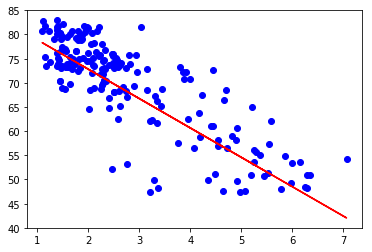

In [12]:
# plot the results
plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data')